In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic

import os

In [3]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
# orbit_path = '../orbits/keplerian_long.h5'
orbit_path = '../orbits/esa-orbits.h5'
gw_path = 'gws_tmp.h5'

# Setup simluation parameters
fs = 0.05    # Hz
# fs = 0.1 # Hz
day = 86400 # s
duration = day # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# Turn on/off binary creation & instrument simulation
use_verbinaries = True
run_new_simulation = False
calculate_new_phases = False
more_accurate_calc = False

# Specify specific number of binaries
Ngalbins = 16

fs = 0.05 Hz,  orbit_duration = 1424.0 d


In [4]:
# Insert binary parameters
amplitude_amplification = 1

if use_verbinaries:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/phishifts/MCMCsample'+str(int(duration))+'s'+'_verbins' #extention of .h5 or .txt added later
    
    rawdata = ascii.read("verbinaries_data_wsource_name.txt")
    
    params = ['lGal', 'bGal', 'orbital_period', 'm1', 'm1e', 'm2', 'm2e', 'i', 'freq', 'par','epar', 'dis', 'edis', 'A', 'eA', 'SNR', 'eSNR']
    # units: lGal [deg], bGal [deg], orbital_period [s], m1 [Msol], m1e [Msol], m2 [Msol], m2e [Msol]
    # i [deg], freq (of gws) [mHz], par [mas], epar [mas], dis [pc], edis [pc], A [1e-23], eA [1e-23], SNR, eSNR
    
    sourcenames = np.array(rawdata["source"])[:Ngalbins]
    Amp_true = (np.array(rawdata["A"])* (1e-23 * amplitude_amplification))[:Ngalbins] # 10yokto to 1e-23 
    f_true = (np.array(rawdata["freq"])* (1e-3))[:Ngalbins] # mHz to Hz
    iota = np.deg2rad(np.array(rawdata["i"]))[:Ngalbins] # deg to rad
    
    # Galactic coordinates of verification binaries   
    source_gal_lon = np.array(rawdata["lGal"])[:Ngalbins]  # degree range from [0,360]
    source_gal_lat = np.array(rawdata["bGal"])[:Ngalbins]  # degree range from [-90,90]

    # Transform coordinates to (barycentric mean) ecliptic coordinates
    gc = SkyCoord(l=source_gal_lon*u.degree, b=source_gal_lat*u.degree, frame='galactic')
    gw_beta_true = np.deg2rad(gc.barycentricmeanecliptic.lon.value)[:Ngalbins] # degree to rad range [0,2pi]
    gw_lambda_true = np.deg2rad(gc.barycentricmeanecliptic.lat.value)[:Ngalbins] # degree to rad range [-pi/2,pi/2]

    # Transform coordinates to equatoral (ICRS) coordinates
    # ra = gc.icrs.ra.value # degree range [0,360]
    # dec = gc.icrs.dec.value # degree range [-90,90]
    
    totNgalbins = len(rawdata["source"])
    phi0_true = np.zeros(Ngalbins)[:Ngalbins]
    print ("Used number of Verification binaries = {} of {} total".format(Ngalbins,totNgalbins))

else:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/phishifts/MCMCsample'+str(int(duration))+'s' #extention of .h5 or .txt added later
    
    Ngalbins = 2
    Amp_true = [1e-16,5e-13]
    f_true = [1e-3,1e-4]
    phi0_true = [0,0]
    gw_beta_true = [0,0]
    gw_lambda_true = [0,np.pi]


Used number of Verification binaries = 16 of 16 total


In [5]:
# Setup galactic binary to insert in simulation

if run_new_simulation:
    for Amp,freq,phase,beta,lamb,verbin,n in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true,sourcenames,range(Ngalbins)):
        print ("For verification binary {}".format(verbin))
        if os.path.exists(gw_path):
            os.remove(gw_path)
            
        source = GalacticBinary(A=Amp, f=freq, phi0=phase, orbits=orbit_path ,t0=orbits_t0 + 1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
        source.write(gw_path)
        
        t0 = time.time()
        sample_instru = Instrument(
            size=size, # in samples
            dt=1/fs,
            aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
            orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
            gws=gw_path
        )
        sample_instru.disable_all_noises()
        sample_instru.simulate()


        # Write out data to sample file, NOTE: Remember to remove the old sample file.
        if os.path.exists(sample_outputf+'_'+str(n)+'.h5'):
            os.remove(sample_outputf+'_'+str(n)+'.h5')
        sample_instru.write(sample_outputf+'_'+str(n)+'.h5')

        print ("Time to run simulation = "+str(time.time()-t0))

        # Read data from LISA Instrument
        rawdata = Data.from_instrument(sample_outputf+'_'+str(n)+'.h5')
        
        if n == 0:
            t0 = time.time()
            Afunc = ortho.A2.build(**rawdata.args)
            A = Afunc(rawdata.measurements)[discard:]
            t1 = time.time()
            print ("Time to build and run A2 = "+str(t1-t0))
            Efunc = ortho.E2.build(**rawdata.args)
            E = Efunc(rawdata.measurements)[discard:]
            t2 = time.time()
            print ("Time to build and run E2 = "+str(t2-t1))
        else:
            t0 = time.time()
            A = Afunc(rawdata.measurements)[discard:]
            t1 = time.time()
            print ("Time to run A2 = "+str(t1-t0))
            E = Efunc(rawdata.measurements)[discard:]
            t2 = time.time()
            print ("Time to run E2 = "+str(t2-t1))

        t = sample_instru.t[discard:]
        # t = (np.arange(0,len(A)+discard)/fs)[discard:]
        
        print (t.shape,A.shape,E.shape)
        sdata = np.array([t,A,E])

        # Extract A, E, T data to speed up re-running code.
        filepath = sample_outputf+'_'+str(n)+'.txt'
        filecontent = Table(sdata.T, names=['t','A','E'])
        ascii.write(filecontent, filepath, overwrite=True)

        t4 = time.time()
        print ("Total time = "+str(t4-t0)+'\n')


In [6]:
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Difference factor between pytdi.Data.from_instrument and pytdi.Data.from_gws

def dphi_to_dnu(time,data):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt = 1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.diff(data) * ((laser_freq) / (2*np.pi*dt))

def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    # Amp, f, phi0 = theta
    newt, y_model = model0(t,y,theta)
    
    return -0.5*(np.sum((y-y_model)**2))
def mlnL(phi0,theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    # Amp, f, phi0 = theta
    newt, y_model = model0(t,y,phi0,theta)
    
    return 0.5*(np.sum((y-y_model)**2))

def model0(st,sA, phi0,theta, gw_beta=gw_beta_true, gw_lambda=gw_lambda_true, t0=orbits_t0+1/fs):
    
    Amp,f= theta
    
    # Generate GW signals
    # for a, f, p, beta, lamb in zip(Amp, f_true, phi0, gw_beta, gw_lambda):
    GalBin = GalacticBinary(A=Amp/f, f=f, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    GalBin.write('gw_tmp.h5')
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws('gw_tmp.h5', orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    #E = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove('gw_tmp.h5')
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(mt,mA)
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]
    
    return np.array([nnmt,nnmA])
    # return np.array([t,A,E,T])


# Building TDI chanel A
if os.path.exists('gw_tmp.h5'):
    os.remove('gw_tmp.h5')
# for a, f, p, beta, lamb in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true):
GalBin = GalacticBinary(A=1e-23, f=1e-3, phi0=0, orbits=orbit_path, t0=orbits_t0+1/fs, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
GalBin.write('gw_tmp.h5')

rawdata = Data.from_gws('gw_tmp.h5',orbit_path,interpolate=True)
os.remove('gw_tmp.h5')

Afunc = ortho.A2.build(**rawdata.args)




In [7]:
# Actually calculating the phi0 for all verification binaries

if calculate_new_phases:
    # Keeping track of time
    time_elapsed = []
    time_elapsed.append(time.time())
    print ("Starting phi0 calculation")

    # Iteration of different phi0's
    N = 100
    phi0_range = np.pi*np.linspace(-1,1,N)
    phi0_actual_true = np.zeros(Ngalbins)

    for Amp,freq,phase,beta,lamb,verbin,n in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true,sourcenames,range(Ngalbins)):
        # Keeping track of time
        time_elapsed.append(time.time())

        # Retreive A, E, T data
        rawdata = ascii.read(sample_outputf+'_'+str(n)+'.txt')
        sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])

        # Create filtered data
        cutoff = 100
        tmp = []
        #coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
        #coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
        coeffs = scipy.signal.firls(73, bands=[0,5e-3,1e-2,fs/2], desired=[1,1,0,0],fs=fs)
        for i in range(1,3):
            fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(sdata[0])//2+1)
            tmp.append(fdata_tmp[cutoff:-cutoff])
        fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1]])


        # Calculate likelyhood for range of phi0
        L = np.zeros(N)
        for i in range(N):
            L[i] = lnL([Amp,freq,phi0_range[i]],fsdata[0],fsdata[1])
        plt.plot(phi0_range,-L)
        plt.title("Phi0 likelyhood for "+verbin)
        plt.xlabel("Phi0 [rad]")
        plt.ylabel("-Likelyhood")
        plt.show()

        # Save the one with minimal L
        index = np.where(L == np.max(L))[0][0]
        print (verbin+": phi0 = {:.3f} rad, time elapsed = {:.2f}s".format(phi0_range[index],time.time()-time_elapsed[-1]))
        phi0_actual_true[n] = phi0_range[index]

    print ("Total time = {:.2f}s".format(time.time()-time_elapsed[0]))
    print ("True values:",phi0_actual_true)
    
    # Writing Verification binary phases to file
    filepath = "verbinaries_phaseoffset_"+str(int(1/fs))+"dt.txt"
    filecontent = Table([sourcenames,phi0_actual_true], names=["source","phi0"])
    ascii.write(filecontent, filepath, overwrite=True)

In [8]:
phi0_actual_true = np.array(ascii.read("verbinaries_phaseoffset_"+str(int(1/fs))+"dt.txt")['phi0'])[:Ngalbins]
print (phi0_actual_true)

[ 0.32314332  0.30617448 -0.36857947 -2.92540085  2.93915944  2.7068752
  2.63707589  1.86997692  1.8001404   1.59089206  1.33540965 -1.78636246
  2.33485334  0.38190874 -0.38506774 -0.47804283]


In [9]:
from scipy.optimize import minimize

if more_accurate_calc:
    phi0_guess = np.copy(phi0_actual_true)
    
    time_elapsed = []
    time_elapsed.append(time.time())
    print ("Starting phi0 calculation")

    # Iteration of different phi0's
    N = 10
    phi0_range = np.pi*np.linspace(-1,1,N)
    phi0_accurate = np.zeros(Ngalbins)

    for Amp,freq,phase,beta,lamb,verbin,n in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true,sourcenames,range(Ngalbins)):
        # Keeping track of time
        time_elapsed.append(time.time())

        # Retreive A, E, T data
        rawdata = ascii.read(sample_outputf+'_'+str(n)+'.txt')
        sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E']])

        # Create filtered data
        cutoff = 100
        tmp = []
        #coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
        #coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
        coeffs = scipy.signal.firls(73, bands=[0,5e-3,1e-2,fs/2], desired=[1,1,0,0],fs=fs)
        for i in range(1,3):
            fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(sdata[0])//2+1)
            tmp.append(fdata_tmp[cutoff:-cutoff])
        fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1]])


        # minimize the -Likelyhood using nelder mead
        res = minimize(mlnL, phi0_guess[n], args=([Amp,freq],fsdata[0],fsdata[1]), method='nelder-mead', )
        new_phi0 = res.x[0]
        print ('For binary {}, difference with old = {} %'.format(n+1, (new_phi0-phi0_guess[n])/phi0_guess[n]*100))
        
        # # Save the one with minimal L
        # print (verbin+": phi0 = {:.3f} rad ({} % diff with old), time elapsed = {:.2f} s".format(new_phi0,(new_phi0-phi0_guess[n])/phi0_guess[n]*100,time.time()-time_elapsed[-1]))
        phi0_accurate[n] = new_phi0
        
    print ("Total time = {:.2f}s".format(time.time()-time_elapsed[0]))
    print ("True values:",phi0_accurate)
    
    # # Writing Verification binary phases to file
    filepath = "verbinaries_phaseoffset_"+str(int(1/fs))+"dt.txt"
    filecontent = Table([sourcenames,phi0_accurate], names=["source","phi0"])
    ascii.write(filecontent, filepath, overwrite=True)

In [10]:
phi0_actual_true = np.copy(phi0_accurate)

NameError: name 'phi0_accurate' is not defined

# Testing if everything worked as planned!

In [11]:
for a, f, p, beta, lamb in zip(Amp_true, f_true, phi0_actual_true, gw_beta_true, gw_lambda_true):
    GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
    # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    GalBin.write('gw_tmp.h5')

rawdata = Data.from_gws('gw_tmp.h5',orbit_path,interpolate=True)#, skipped=-int(size))

Afunc = ortho.A2.build(**rawdata.args)
A = Afunc(rawdata.measurements)[discard:]
Efunc = ortho.E2.build(**rawdata.args)
E = Efunc(rawdata.measurements)[discard:]

t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]

mdata = np.array([t,A])
nmdata = np.array([t[:-1],dphi_to_dnu(t,A),dphi_to_dnu(t,E)])

os.remove('gw_tmp.h5')

In [12]:
if os.path.exists(gw_path):
    os.remove(gw_path)

for a,f,p,beta,lamb in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true):
    source = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 1/fs, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
    source.write(gw_path)

# Create 'realistic' orbit with signal and noise

t0 = time.time()
sample_instru = Instrument(
    size=size, # in samples
    dt=1/fs,
    aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
    orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
    gws=gw_path
)
sample_instru.disable_all_noises()
sample_instru.simulate()


# Write out data to sample file, NOTE: Remember to remove the old sample file.
if os.path.exists(sample_outputf+'.h5'):
    os.remove(sample_outputf+'.h5')
sample_instru.write(sample_outputf+'.h5')

print ("Time to run simulation = "+str(time.time()-t0))

# Read data from LISA Instrument
rawdata = Data.from_instrument(sample_outputf+'.h5')

t0 = time.time()
A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
t1 = time.time()
print ("Time to build and run A2 = "+str(t1-t0))
E = ortho.E2.build(**rawdata.args)(rawdata.measurements)[discard:]
t2 = time.time()
print ("Time to build and run E2 = "+str(t2-t1))
T = ortho.T2.build(**rawdata.args)(rawdata.measurements)[discard:]
t3 = time.time()
print ("Time to build and run T2 = "+str(t3-t2))

#t = sample_instru.t[discard:]
t = (np.arange(0,len(A)+discard)/fs)[discard:]

sdata = np.array([t,A,E,T])

# Extract A, E, T data to speed up re-running code.
filepath = sample_outputf+'.txt'
filecontent = Table(sdata.T, names=['t','A','E','T'])
ascii.write(filecontent, filepath, overwrite=True)

t4 = time.time()
print ("Total time = "+str(t4-t0))

Time to run simulation = 0.6948235034942627
Time to build and run A2 = 1.4498538970947266
Time to build and run E2 = 2.135209798812866
Time to build and run T2 = 2.7499897480010986
Total time = 6.355290174484253


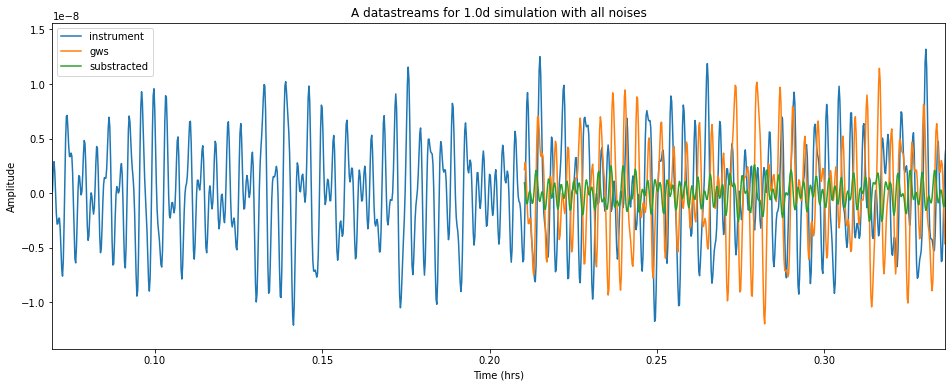

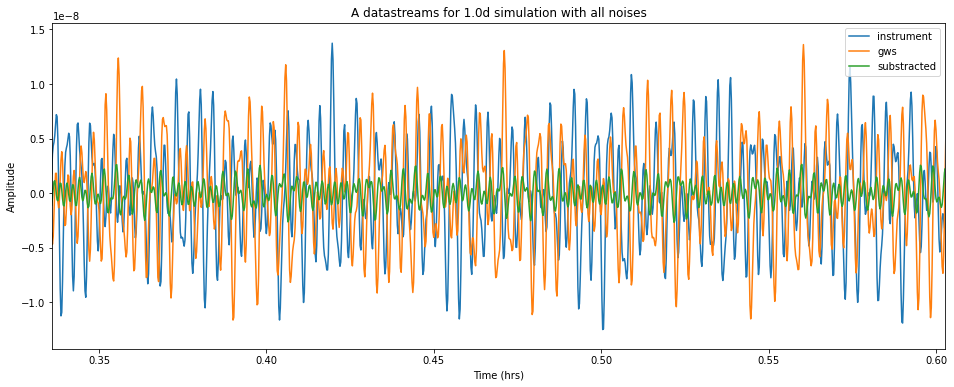

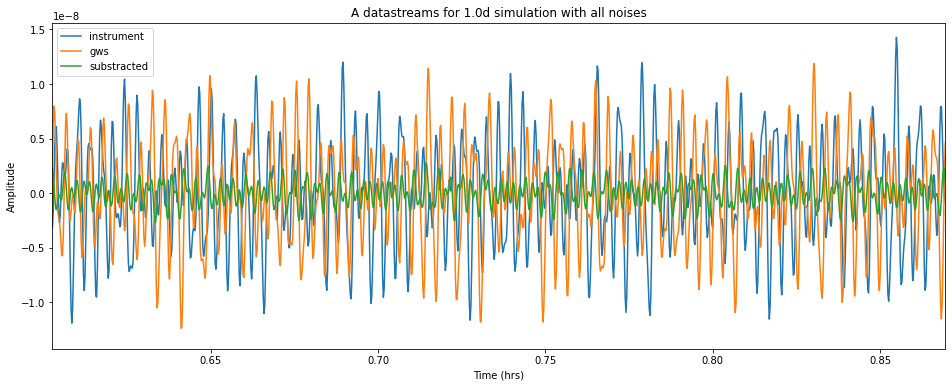

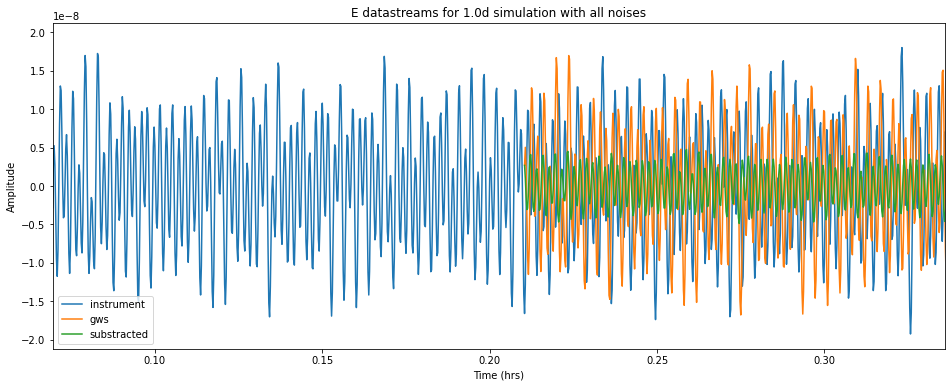

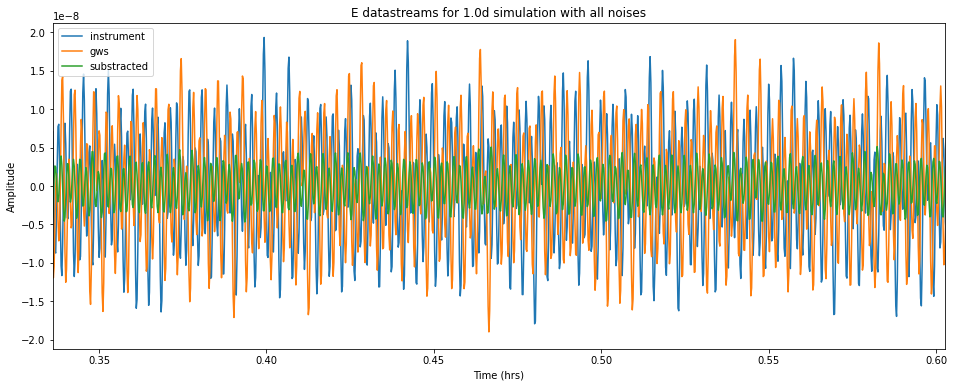

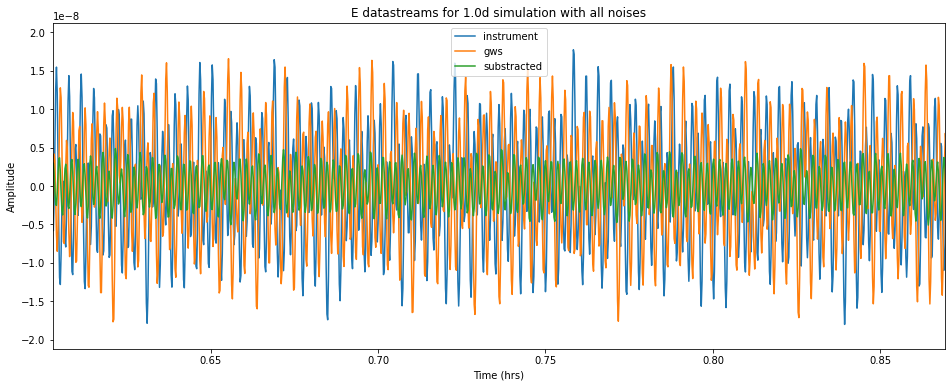

In [13]:
tmp = np.min(sdata[0]/day) + np.linspace(0,0.8,4)

for i in range(2):
    for mi,ma in zip(tmp[:-1],tmp[1:]):
        avg = (sdata[i+1][1:]+sdata[i+1][:-1])/2
        plt.figure(figsize=(16,6))
        plt.plot(sdata[0]/day,sdata[i+1],label="instrument")
        plt.plot(nmdata[0]/day,nmdata[i+1],label="gws")
        plt.plot((nmdata[0]/day)[:-300],(nmdata[i+1])[:-300]-avg,label="substracted")
        plt.title(rec[i]+' datastreams for '+str(duration/day)+'d simulation with all noises')
        plt.legend()
        plt.xlabel('Time (hrs)')
        plt.ylabel('Amplitude')
        plt.xlim(mi,ma)
        plt.show()

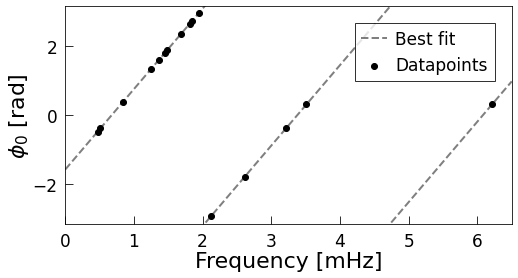

[ 2.32473081e+03 -1.57069369e+00]


In [20]:
from scipy.optimize import curve_fit
plt.style.use('style.mplstyle')



def line(x,a,b):
    return a*x+b

# Fit a straight line to the first line of datapoints
mask = f_true< 2e-3
popt,pcov = curve_fit(line, f_true[mask], phi0_actual_true[mask])

x = np.linspace(0,6.5e-3,1000)
plt.figure(figsize=(8,4))
plt.scatter(f_true*1e3,phi0_actual_true,c='black',zorder=5,label='Datapoints')
def plot_line(offset=0):
    if offset ==0:
        plt.plot(x*1e3,line(x,popt[0],popt[1]-offset*2*np.pi),c='black',linestyle='--',alpha=0.5,label='Best fit')
    else:
        plt.plot(x*1e3,line(x,popt[0],popt[1]-offset*2*np.pi),c='black',alpha=0.5,linestyle='--')
for i in range(3):
    plot_line(i)

plt.ylim(-np.pi,np.pi)
plt.xlim(0,6.5)
plt.xlabel("Frequency [mHz]")
plt.ylabel("$\phi_0$ [rad]")
# plt.title("Phase offset of gravitational waves plotted against their frequencies")
plt.legend(loc=1)
plt.savefig("plots/phase_offset_relation.pdf")
plt.show()
print (popt)